<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function should append to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function should also handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [3]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

# you should pass empty X and y to function load_window_dataset
X=None 
y=None
length=10
spacing=1
folderpath='Features'

for filename in os.listdir(folderpath):
    #F: you should continue iterating over "Features" folder looking for the desired files    
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

#All scenario correlated ONLY TO "length=10" and "spacing=1"
print(X)
print(y)
print(X.shape)
print(y.shape)

# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X)
print(y)
print(X.shape)
print(y.shape)



Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [4]:
############################################################################################################
###### Performs hyperparameter optimization with 5-fold crossvalidation and training 
###### for XGB with given hyperparameters space 
###### XGB documentation at: https://xgboost.readthedocs.io/en/stable/python/python_intro.html 
###### XGB hyperparameters: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html 
############################################################################################################

#Last time we did it with nested for loops
def train_classifier_XGB(X_train, y_train, resfileXGB): 
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - resfileXGB: full name (with path) of the results file where to put output of the training/optimization process
#                      resfileXGB should include info on: 
#                              1) ML algorithm
#                              2) problem (detection or identification)
#                              3) window length and window spacing
#
#This function should: 
#         * Perform XGBoost hyperparameters optimization via crossvalidation
#         * Print hyperparameters obtained with crossvalidation in resfileXGB
#         * Retrain an XGB model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration) in resfileXGB
#         * Return the trained XGB model
#
#Outputs: - updated resfileXGB with:
#                              1) best hyperparameters obtained with crossvalidation
#                              2) best accuracy obtained during crossvalidation (for the best hyperparameters)
#                              3) duration of training over the entire training set (X_train, y_train)
#         - xgb: model to be returned by the function



    #F: define the search space for your hyperparameters - a space where to search
    # These parameters are needed to balance between underfitting and overfitting
    # We are testing 3 hyperparameters: eta, max_depth and subsample
    space4xgb = { 
     'eta': hp.choice('eta', [0.1, 0.3, 0.5, 0.7, 0.9, 1]),
     #max_depth (maximum depth of the decision trees being trained)
     'max_depth': hp.choice('max_depth', np.arange(1, 20, 2)),
     'subsample': hp.choice('subsample', [0.1, 0.3, 0.5, 0.7, 0.9, 1])
    }

    # hyperopt is used to perform an efficent search in the space of parameters
    def hyperopt_train_test(params):
        model = XGBClassifier(use_label_encoder=False, verbosity = 0, **params)
        #F: see https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
        
        return cross_val_score(model, X_train, y_train, cv = 5).mean()
        #F: cross_val_score is from scikit learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        #F: will use the default score (for XGB it is accuracy)
        #F: this includes also training; cv=5 (5 number of folds) (5-folds crossvalidation)
        #F: .mean() is taken as cross_val_score returns an array of scores (one for each fold)
        # We have to do the mean because "cross_val_score" returns the accuracy of all the folds

    #We pass to this function the "space4xgb" parameter (in fmin() function)
    #F: this function is used below, as a parameter to fmin
    def f(params): 
        # assumes that "hyperopt_train_test" gives use the best cross validation accuracy 
        # given that combination of hyperparameters (params)
        acc = hyperopt_train_test(params)
        #F: loss is returned as opposite (negative) of accuracy because we will use in 
        #f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)
        # We need to return these parameters because fmin() requires them
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    trials = Trials()
    #best_params stores the index of the best parameters values according to the function
    # fmin() returns the indexes based on the minimum value of a passed function "f"
    # space4xgb is the search space
    # algo=tpe.suggest is the used alorithm
    # max_evals=5 is the maximum trials
    best_params = fmin(f, space4xgb, algo=tpe.suggest, max_evals=5, trials=trials)
    #F: see: https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
    #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4xgb
    print(best_params)
    
    #Insert in the paramets the values of the hyperparameters (not the indexes)
    best_params = hyperopt.space_eval(space4xgb, best_params)
    #F: this is used to extract from space4xgb the best values according to the indexes in best_params (and put such values in best_params)
    print(best_params)
    
    best_cv_acc = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
    print('best_cv_acc: ' + str(best_cv_acc))

#######################################################################################################
###### Task 4a) (cont.) Now store hyperparameters obtained with crossvalidation in file resfileXGB
######                  Train the obtained model using the entire training set and store training time in resfileXGB
######                  Return the trained model
#######################################################################################################

    xgb = XGBClassifier(eta = best_params['eta'], max_depth= best_params['max_depth'], 
                            subsample = best_params['subsample'], use_label_encoder=False, verbosity = 0) 

    t0 = time.time()
    #F: fit() is a function from scikit learn interface for XGB (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#scikit-learn-interface), 
    # there is also train() that can be used directly with XGB objects (https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training) 
    xgb.fit(X_train, y_train) 
    t1 = time.time()

    with open(resfileXGB, 'w') as result_file:
        result_file.write('Best eta: {}\n'.format(best_params['eta']))
        result_file.write('Best max depth: {}\n'.format(best_params['max_depth']))
        result_file.write('Best subsample: {}\n'.format(best_params['subsample']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
        result_file.write('Training duration for XGB is {} s\n'.format(round(t1 - t0)))

    return xgb




In [5]:
############################################################################################################
###### Performs hyperparameter optimization and training for DNN with given hyperparameters space 
############################################################################################################

def train_classifier_DNN(X_train, y_train, resfileDNN): 
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - resfileDNN: full name (with path) of the results file where to put output of the training/optimization process
#                      resfileDNN should include info on: 
#                              1) ML algorithm
#                              2) problem (detection or identification)
#                              3) window length and window spacing
#
#This function should: 
#         * Perform DNN hyperparameters optimization via crossvalidation
#         * Print hyperparameters obtained with crossvalidation in resfileDNN
#         * Retrain a DNN model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration) in resfileDNN
#         * Return the trained DNN model
#
#Outputs: - updated resfileDNN with:
#                              1) best hyperparameters obtained with crossvalidation
#                              2) best accuracy obtained during crossvalidation (for the best hyperparameters)
#                              3) duration of training over the entire training set (X_train, y_train)
#         - dnn: model to be returned by the function

    #F: define the search space for your hyperparameters
    space4dnn = {
     'activation': hp.choice('activation', ['logistic', 'tanh', 'relu']),
     'neurons': hp.choice('neurons', [10, 50, 100]),
     'layers': hp.choice('layers', np.arange(1, 4, 1))
    }

    def hyperopt_train_test(params):
        size = (params['neurons'],) * params['layers']
        dnn = MLPClassifier(hidden_layer_sizes=size, activation=params['activation'],
                            solver='adam', learning_rate='invscaling', max_iter=1000)
        return cross_val_score(dnn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    trials = Trials()
    best_params = fmin(f, space4dnn, algo=tpe.suggest, max_evals=5, trials=trials)
    print(best_params) 
    
    best_params = hyperopt.space_eval(space4dnn, best_params)
    print(best_params) 
    
    best_cv_acc = -round(trials.best_trial['result']['loss'], 2)
    print('best_cv_acc: ' + str(best_cv_acc))
    
    
    size = (best_params['neurons'],) * best_params['layers']
    dnn = MLPClassifier(hidden_layer_sizes=size, activation=best_params['activation'],
                                solver='adam', learning_rate='invscaling', max_iter=1000)

    t0 = time.time()
    dnn.fit(X_train, y_train)
    t1 = time.time()

    with open(resfileDNN, 'w') as result_file:
        result_file.write('Best number of layers: {}\n'.format(best_params['layers']))
        result_file.write('Best number of neurons: {}\n'.format(best_params['neurons']))
        result_file.write('Best activation function: {}\n'.format(best_params['activation']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
        result_file.write('Training duration for DNN is {} s\n'.format(round(t1 - t0)))


    return dnn


In [6]:
############################################################################################################
###### Performs hyperparameter optimization and training for KNN with given hyperparameters space 
############################################################################################################

def train_classifier_KNN(X_train, y_train, resfileKNN): 

    #F: define the search space for your hyperparameters
    space4knn = {
     'leaf_size': hp.choice('leaf_size', np.arange(1, 50, 1)),
     'p': hp.choice('p', [1, 2]),
     'n_neighbors': hp.choice('n_neighbors', np.arange(1, 30, 1))
    }

    def hyperopt_train_test(params):
        knn = KNeighborsClassifier(leaf_size=params['leaf_size'], p=params['p'], 
                                   n_neighbors=params['n_neighbors'])
        return cross_val_score(knn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    trials = Trials()
    best_params = fmin(f, space4knn, algo=tpe.suggest, max_evals=5, trials=trials)
    print(best_params) 
    
    best_params = hyperopt.space_eval(space4knn, best_params)
    print(best_params) 
    
    best_cv_acc = -round(trials.best_trial['result']['loss'], 2)
    print('best_cv_acc: ' + str(best_cv_acc))
    
    knn = KNeighborsClassifier(leaf_size=best_params['leaf_size'], p=best_params['p'], 
                                   n_neighbors=best_params['n_neighbors'])

    t0 = time.time()
    knn.fit(X_train, y_train)
    t1 = time.time()

    with open(resfileKNN, 'w') as result_file:
        result_file.write('Best leaf_size: {}\n'.format(best_params['leaf_size']))
        result_file.write('Best number of p: {}\n'.format(best_params['p']))
        result_file.write('Best number of neighbors: {}\n'.format(best_params['n_neighbors']))
        result_file.write('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
        result_file.write('Training duration for kNN is {} s\n'.format(round(t1 - t0)))


    return knn


In [7]:
################################################################################################################
###### Split (X,y) obtained in task 3b (they had window length=10 and spacing=1) into train/test 
###### sets (80%/20%). Then, call functions train_classifier_XGB() and train_classifier_DNN(). 
###### Save trained models (returned by the three functions) into .json files.
################################################################################################################
res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

resfile_XGB=res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'
resfile_DNN=res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'
resfile_KNN=res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'

# Stratify garantees the split all the scenarios among train and test
# It's like shuffle and split
# random_state it's a seed to get the same output
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(y_test)
print(X_test)


print('Training XGB...')
xgb = train_classifier_XGB(X_train, y_train, resfile_XGB)

print('Training DNN...')
dnn = train_classifier_DNN(X_train, y_train, resfile_DNN)

print('Training KNN...')
knn = train_classifier_KNN(X_train, y_train, resfile_KNN)

[0 0 0 ... 0 0 0]
[[-0.07903669 -0.07905794 -0.53654565 -0.31595749 -0.08354188 -0.07399217]
 [ 0.31163765  0.31161641 -0.80095167 -1.0687397   0.30754744  0.32255547]
 [-0.07279471 -0.07281596  0.70412873  0.56228842 -0.05859435 -0.07141957]
 ...
 [-1.19341323 -1.19343447 -0.86196844 -0.62961674 -1.19627541 -1.18278198]
 [ 0.32595748  0.32593624 -0.4958678  -0.50415304  0.31378433  0.32329049]
 [-0.03571003 -0.03573127  0.74480657  0.56228842 -0.0277768  -0.04128342]]
Training XGB...
100%|█████████████████████████████████████████████████| 5/5 [04:38<00:00, 55.65s/trial, best loss: -0.9993137661688811]
{'eta': 5, 'max_depth': 3, 'subsample': 3}
{'eta': 1, 'max_depth': 7, 'subsample': 0.7}
best_cv_acc: 1.0
Training DNN...
100%|████████████████████████████████████████████████| 5/5 [18:10<00:00, 218.19s/trial, best loss: -0.9983806165981072]
{'activation': 1, 'layers': 1, 'neurons': 2}
{'activation': 'tanh', 'layers': 2, 'neurons': 100}
best_cv_acc: 1.0
Training KNN...
100%|██████████████

In [8]:
# Define model names
xgbmodelfile = res_folder + '/XGB_sp{}_w{}.json'.format(spacing, length) 
dnnmodelfile = res_folder + '/DNN_sp{}_w{}.json'.format(spacing, length)
knnmodelfile = res_folder + '/KNN_sp{}_w{}.json'.format(spacing, length)

In [9]:
# Save the models to disk
xgb.save_model(xgbmodelfile)
pickle.dump(dnn, open(dnnmodelfile, 'wb'))
pickle.dump(knn, open(knnmodelfile, 'wb'))

C:\Users\marsl\anaconda3\lib\site-packages\xgboost\sklearn.py:722: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


In [10]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics (details below) 
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names, resfile):
#Inputs: - y_true: ground-truth labels
#        - y_pred: predicted labels

# lab and l_names are two ways of defining the lables
# lab = (0,1)
# l_names = used for plotting = ['Attenuation', 'Filtering']

#        - lab: list of labels (integers) as used during training phase
#        - l_names: list of labels (categories) corresponding to integer labels "lab"; 
#                   can be customized, it's only used for results plotting
#        - resfile: full name (with path) of the results file where to put performance metrics
#This function should:            
#         * Compute Accuracy, Precision (global-weighted and per class), Recall (global-weighted and per class), F1-score (global-weighted and per class)
#         * Write them in result .txt file (resfile passed in input)
#         * Compute confusion matrix (cm) and save it in the same result .txt file (resfile)
#         * Return Accuracy, overall Precision, overall Recall, overall F1-score
#         * Plot of the cm is already given in the code (you need to call the confusion matrix objects as cm and cm_norm)
#Outputs: - updated resfileDNN with:
#                              1) Accuracy, Precision (global-weighted and per class), Recall (global-weighted and per class), F1-score (global-weighted and per class)
#                              2) Confusion matrix (cm) and confusion matrix normalized wrt true labels (cm_norm)
#         - return accuracy, global_precision, global_recall, global_f1score (use these variable names!)
    
    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #F: normalized wrt true labels (axis=1 sums the elements of one row and sums them; this is done for all the rows independently)

    with open(resfile, 'w') as result_file:
        result_file.write('Results for the TEST SET\n')
        result_file.write('Accuracy: {}\n'.format(accuracy))
        result_file.write('Precision per class: {}\n'.format(precision))
        result_file.write('Global Precision: {}\n'.format(global_precision))
        result_file.write('Recall per class: {}\n'.format(recall))
        result_file.write('Global Recall: {}\n'.format(global_recall))
        result_file.write('F1-score: {}\n'.format(f1score))
        result_file.write('Global F1-score: {}\n'.format(global_f1score))
        
        result_file.write('\nConfusion matrix, without normalization\n')
        np.savetxt(result_file, cm, fmt = '%.2f')

        result_file.write('\nNormalized confusion matrix\n')
        #np.savetxt(result_file, cm_norm, fmt = '%.2f')
        result_file.write(str(cm_norm))

        
        
########################################################################
#F: in the following, we plot the confusion matrices (absolute and normalized one)
# ------------------------------- absolute -------------------------------
        title = 'Confusion matrix, without normalization'
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               #xticklabels=lab, yticklabels=lab,
               xticklabels=l_names, yticklabels=l_names,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions (#F: i.e., cells in the confusion matrix) and create text annotations. 
        fmt = 'd'
        thresh = cm.max() / 2.
        for w in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, w, format(cm[w, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[w, j] > thresh else "black")
        fig.tight_layout()
        fig.savefig(resfile.replace('.txt','_conf_matrix.png'))
        plt.show()
# ------------------------------- normalized -------------------------------
        title_norm = 'Confusion matrix, with normalization'
        fig_n, ax_n = plt.subplots()
        im = ax_n.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
        ax_n.figure.colorbar(im, ax=ax_n)
        # We want to show all ticks...
        ax_n.set(xticks=np.arange(cm_norm.shape[1]),
               yticks=np.arange(cm_norm.shape[0]),
               # ... and label them with the respective list entries
               #xticklabels=lab, yticklabels=lab,
               xticklabels=l_names, yticklabels=l_names,
               title=title_norm,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax_n.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions (#F: i.e., cells in the confusion matrix) and create text annotations. 
        fmt = '.2f'
        thresh = cm_norm.max() / 2.
        for w in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                ax_n.text(j, w, format(cm_norm[w, j], fmt),
                        ha="center", va="center",
                        color="white" if cm_norm[w, j] > thresh else "black")
        fig_n.tight_layout()
        fig_n.savefig(resfile.replace('.txt','_conf_matrix_normalized.png'))
        plt.show()

########################################################################
# Now we return the global metrics (Accuracy, Precision, Recall, F1-score) calculated above

    return accuracy, global_precision, global_recall, global_f1score 


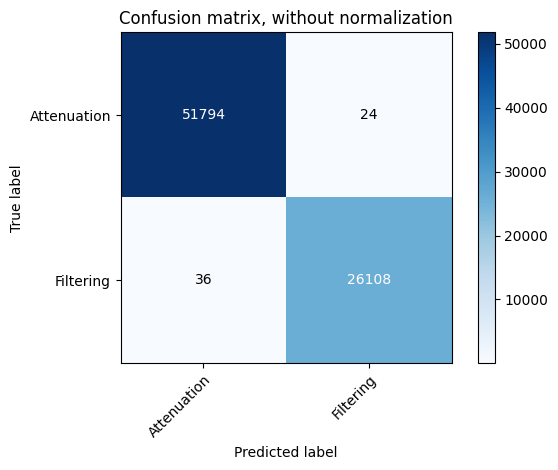

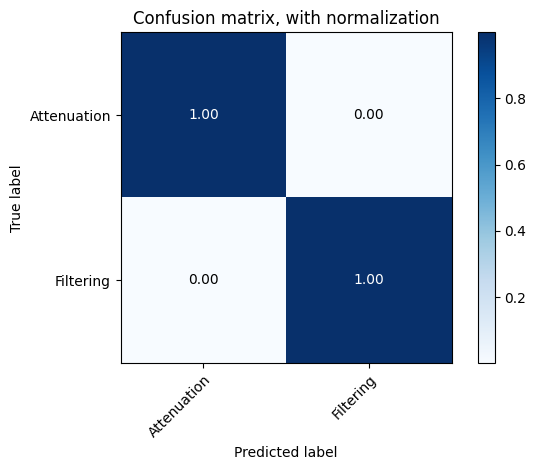

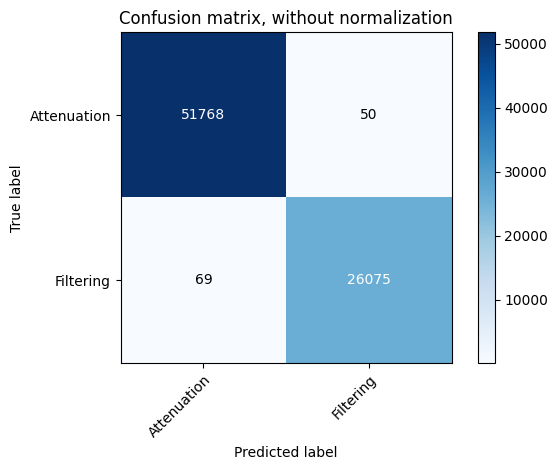

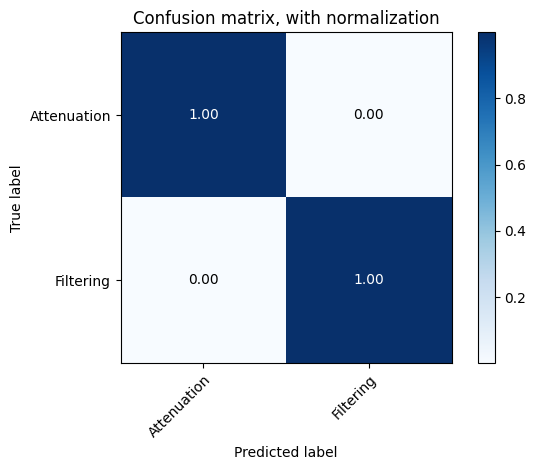

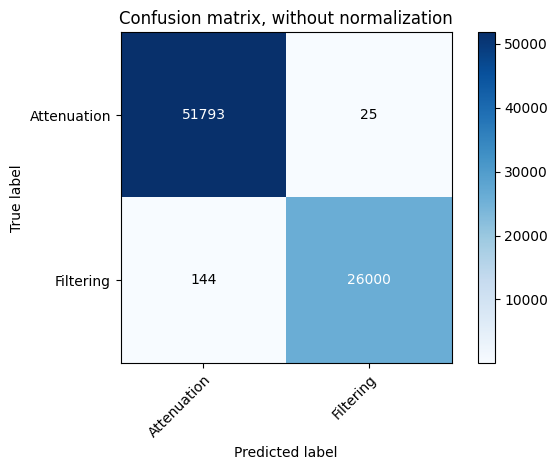

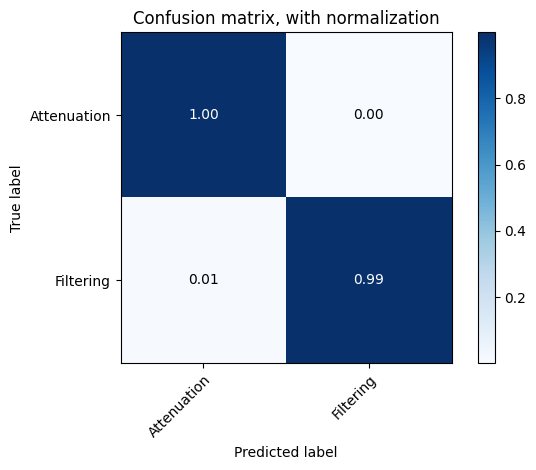

XGB metrics: (0.9992303942946563, 0.9992303598415985, 0.9992303942946563, 0.9992303505139537)
****************
DNN metrics: (0.9984736153510685, 0.9984734733226325, 0.9984736153510685, 0.9984734778209048)
****************
KNN metrics: (0.9978322772632822, 0.9978350430342208, 0.9978322772632822, 0.9978310480393541)


In [11]:
##############################################################################################################
###### Task 5b) Load models trained in task 4c) into two NEW models, then perform prediction for the #########
######          test set retrieved in task 4c). Evaluate performance using performance_eval() ################
######          Hint: use load_model for XGB and pickle.load for DNN (GIVEN IN THE CODE BELOW) ###############
##############################################################################################################
restestfileXGB = res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
restestfileDNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
restestfileKNN = res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'

# load the model from disk
loaded_xgb = XGBClassifier()
loaded_xgb.load_model(xgbmodelfile)

# load the model from disk
loaded_dnn = pickle.load(open(dnnmodelfile, 'rb'))

# load the model from disk
loaded_knn = pickle.load(open(knnmodelfile, 'rb'))

lbl = [0, 1]
label_names=['Attenuation', 'Filtering']
############# ADD YOUR CODE BELOW #############

# Added to fix: 'XGBClassifier' object has no attribute '_le'
loaded_xgb._le = LabelEncoder().fit(y_test)

y_pred_XGB = loaded_xgb.predict(X_test)
y_pred_DNN = loaded_dnn.predict(X_test)
y_pred_KNN = loaded_knn.predict(X_test)

XGB_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names, restestfileXGB)
DNN_metrics = performance_eval(y_test, y_pred_DNN, lbl, label_names, restestfileDNN)
KNN_metrics = performance_eval(y_test, y_pred_KNN, lbl, label_names, restestfileKNN)

print('XGB metrics: ' +str(XGB_metrics))
print('****************')
print('DNN metrics: ' +str(DNN_metrics))
print('****************')
print('KNN metrics: ' +str(KNN_metrics))

********************************
Iteration for spacing=1 and window length=10
1) Loading dataset into (XX,yy)...
[[18.815 18.815  0.141  0.052 18.893 18.752]
 [18.816 18.816  0.141  0.052 18.893 18.752]
 [18.824 18.824  0.141  0.048 18.893 18.752]
 ...
 [24.105 24.105  0.109  0.033 24.166 24.057]
 [24.117 24.117  0.099  0.035 24.175 24.076]
 [24.123 24.123  0.099  0.036 24.175 24.076]]
[[0.052]
 [0.052]
 [0.048]
 ...
 [0.033]
 [0.035]
 [0.036]]
2) Hyperparameters optimization and training...
Training XGB...
100%|█████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.95s/trial, best loss: -0.7068496664956389]
{'eta': 0, 'max_depth': 1, 'subsample': 4}
{'eta': 0.1, 'max_depth': 3, 'subsample': 0.9}
best_cv_acc: 0.71
Training DNN...
100%|█████████████████████████████████████████████████| 5/5 [02:03<00:00, 24.62s/trial, best loss: -0.7081836839404823]
{'activation': 1, 'layers': 1, 'neurons': 1}
{'activation': 'tanh', 'layers': 2, 'neurons': 50}
best_cv_acc: 0.71
Training 

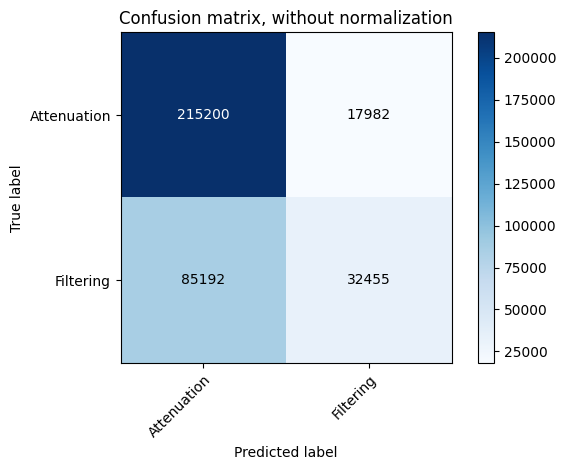

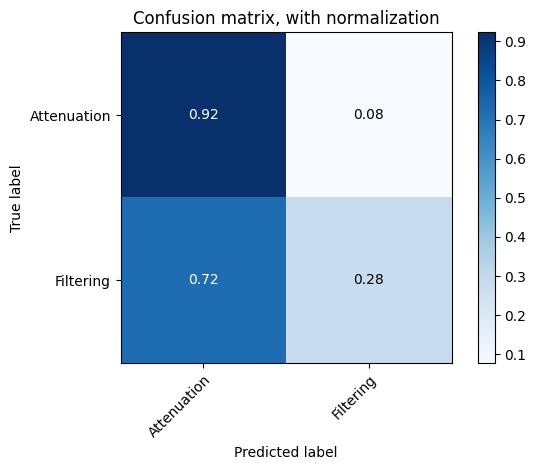

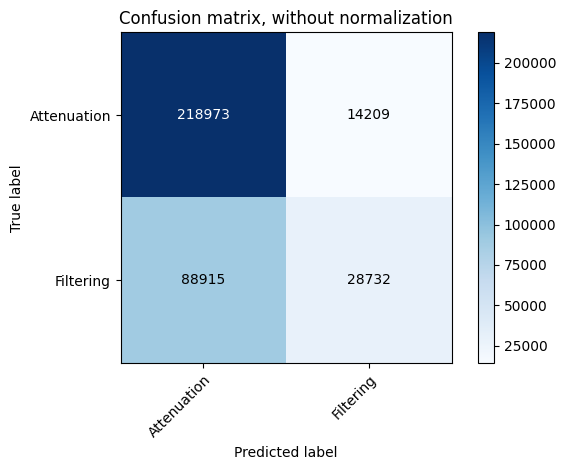

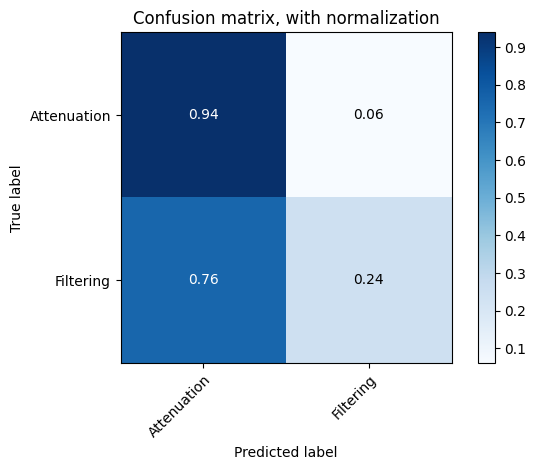

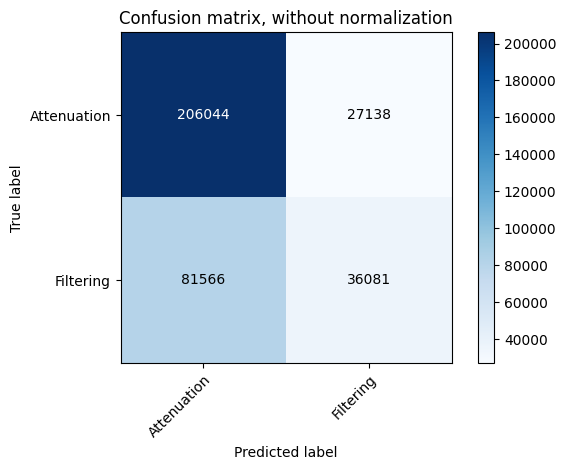

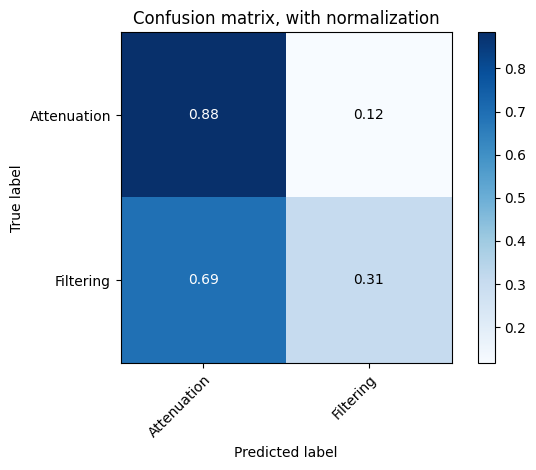

********************************
Iteration for spacing=1 and window length=40
1) Loading dataset into (XX,yy)...
[[18.819 18.819  0.181  0.049 18.893 18.712]
 [18.818 18.818  0.181  0.05  18.893 18.712]
 [18.82  18.82   0.181  0.048 18.893 18.712]
 ...
 [24.106 24.106  0.128  0.038 24.171 24.043]
 [24.108 24.108  0.132  0.039 24.175 24.043]
 [24.108 24.108  0.132  0.039 24.175 24.043]]
[[0.049]
 [0.05 ]
 [0.048]
 ...
 [0.038]
 [0.039]
 [0.039]]
2) Hyperparameters optimization and training...
Training XGB...
100%|█████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.90s/trial, best loss: -0.7346145821545074]
{'eta': 3, 'max_depth': 7, 'subsample': 3}
{'eta': 0.7, 'max_depth': 15, 'subsample': 0.7}
best_cv_acc: 0.73
Training DNN...
100%|█████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.71s/trial, best loss: -0.7347687412376224]
{'activation': 1, 'layers': 1, 'neurons': 1}
{'activation': 'tanh', 'layers': 2, 'neurons': 50}
best_cv_acc: 0.73
Training

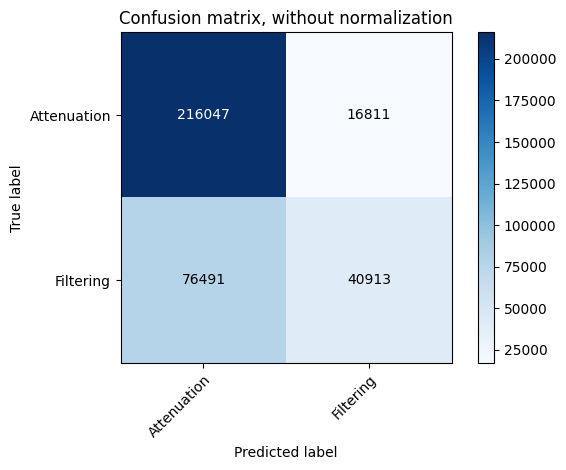

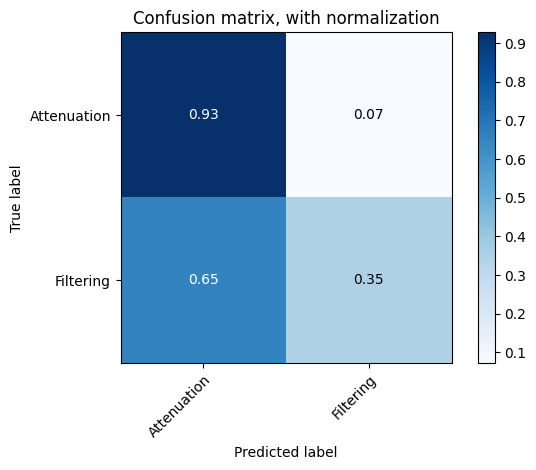

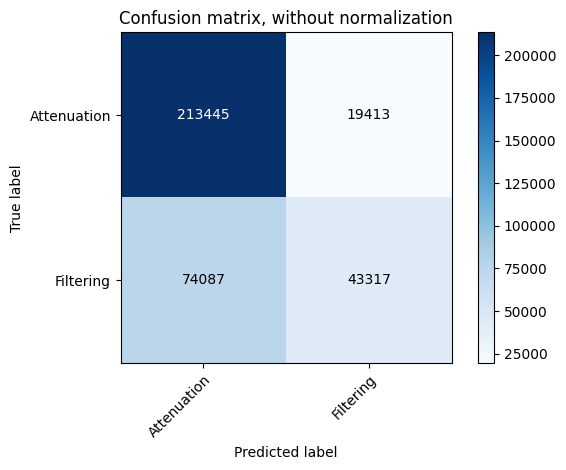

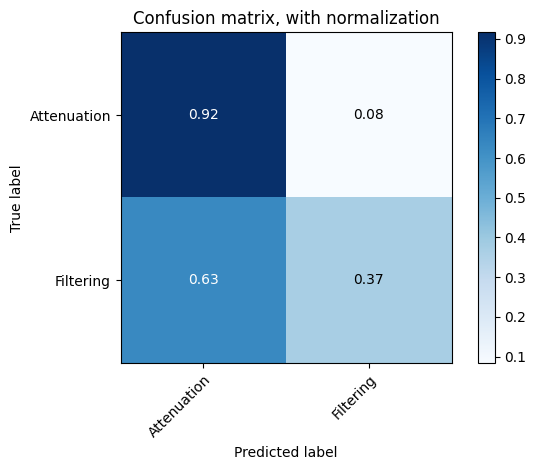

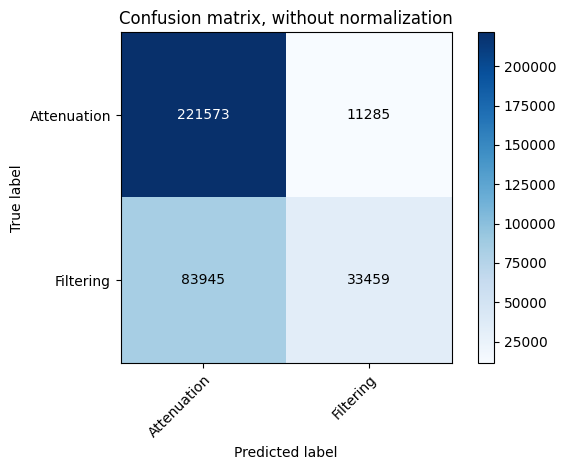

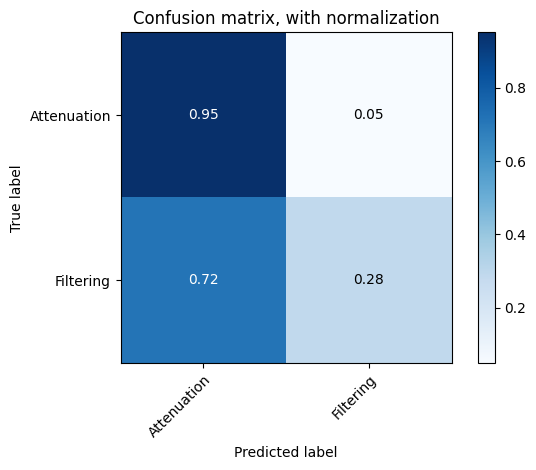

********************************
Iteration for spacing=1 and window length=70
1) Loading dataset into (XX,yy)...
[[18.808 18.808  0.231  0.058 18.893 18.662]
 [18.808 18.808  0.231  0.058 18.893 18.662]
 [18.809 18.809  0.231  0.057 18.893 18.662]
 ...
 [24.111 24.111  0.14   0.041 24.183 24.043]
 [24.111 24.111  0.14   0.042 24.183 24.043]
 [24.111 24.111  0.14   0.042 24.183 24.043]]
[[0.058]
 [0.058]
 [0.057]
 ...
 [0.041]
 [0.042]
 [0.042]]
2) Hyperparameters optimization and training...
Training XGB...
100%|█████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.14s/trial, best loss: -0.7430895980452024]
{'eta': 4, 'max_depth': 7, 'subsample': 3}
{'eta': 0.9, 'max_depth': 15, 'subsample': 0.7}
best_cv_acc: 0.74
Training DNN...
100%|█████████████████████████████████████████████████| 5/5 [05:33<00:00, 66.60s/trial, best loss: -0.7427035473438768]
{'activation': 1, 'layers': 0, 'neurons': 2}
{'activation': 'tanh', 'layers': 1, 'neurons': 100}
best_cv_acc: 0.74
Trainin

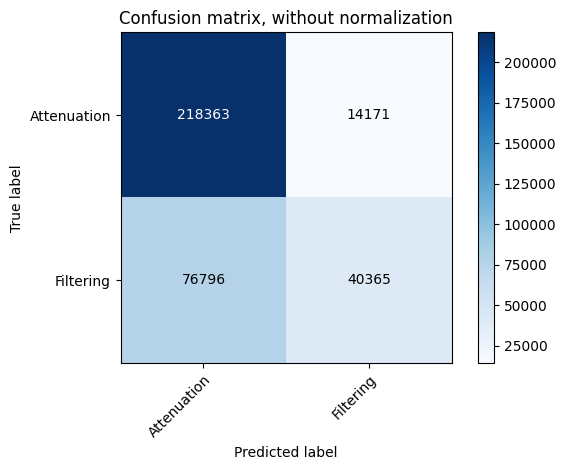

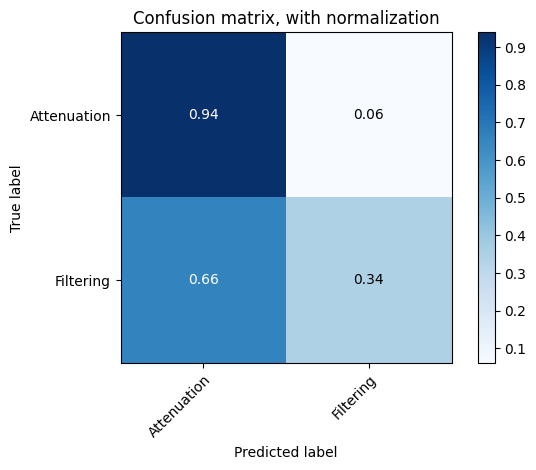

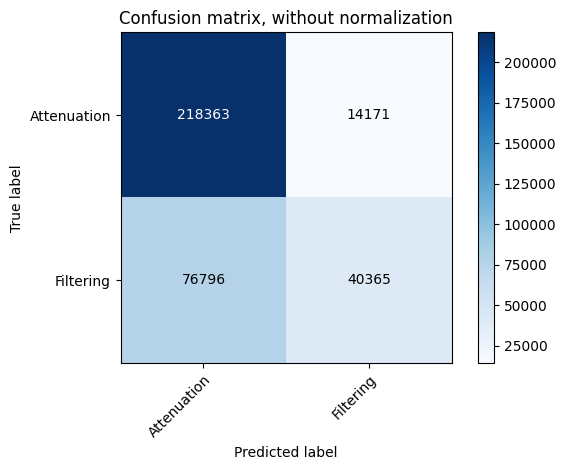

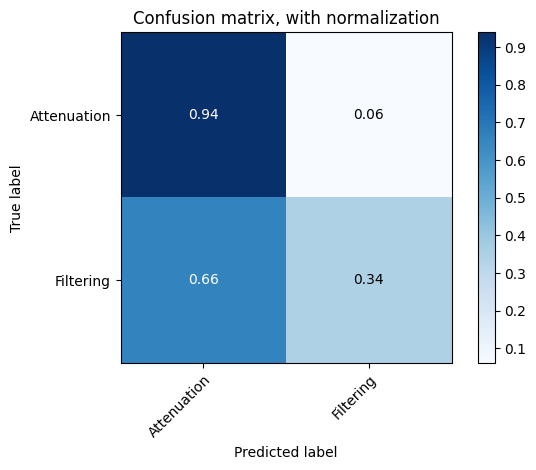

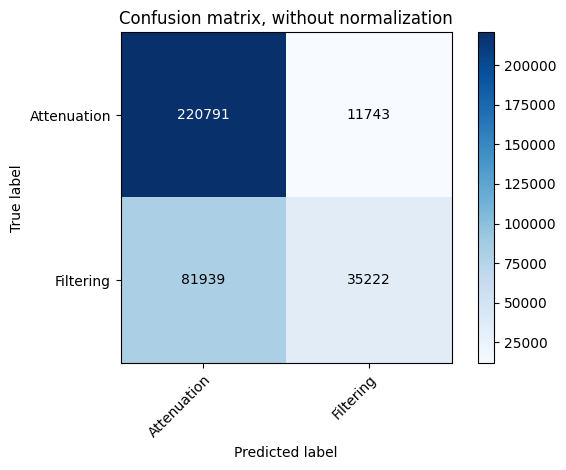

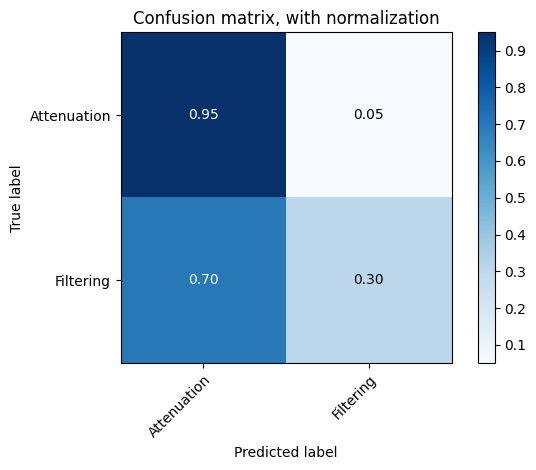

********************************
Iteration for spacing=1 and window length=100
1) Loading dataset into (XX,yy)...
[[18.803 18.803  0.243  0.058 18.905 18.662]
 [18.802 18.802  0.243  0.058 18.905 18.662]
 [18.803 18.803  0.243  0.058 18.905 18.662]
 ...
 [24.111 24.111  0.14   0.041 24.183 24.043]
 [24.111 24.112  0.14   0.041 24.183 24.043]
 [24.111 24.112  0.14   0.041 24.183 24.043]]
[[0.058]
 [0.058]
 [0.058]
 ...
 [0.041]
 [0.041]
 [0.041]]
2) Hyperparameters optimization and training...
Training XGB...
100%|█████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.68s/trial, best loss: -0.7474928216651398]
{'eta': 5, 'max_depth': 6, 'subsample': 5}
{'eta': 1, 'max_depth': 13, 'subsample': 1}
best_cv_acc: 0.75
Training DNN...
100%|█████████████████████████████████████████████████| 5/5 [03:05<00:00, 37.18s/trial, best loss: -0.7478280061032999]
{'activation': 1, 'layers': 0, 'neurons': 1}
{'activation': 'tanh', 'layers': 1, 'neurons': 50}
best_cv_acc: 0.75
Training KN

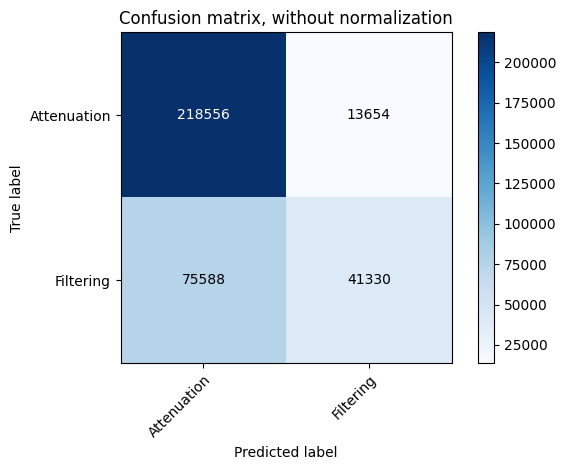

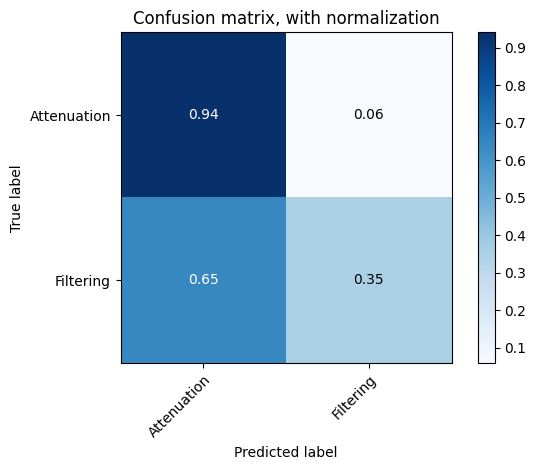

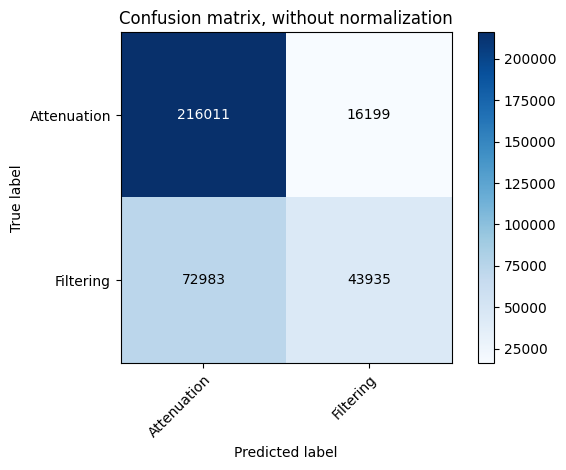

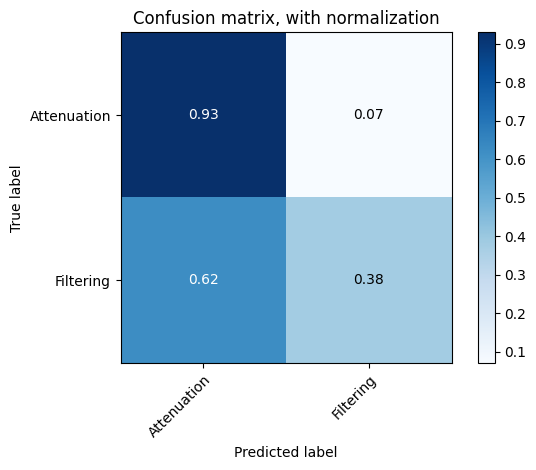

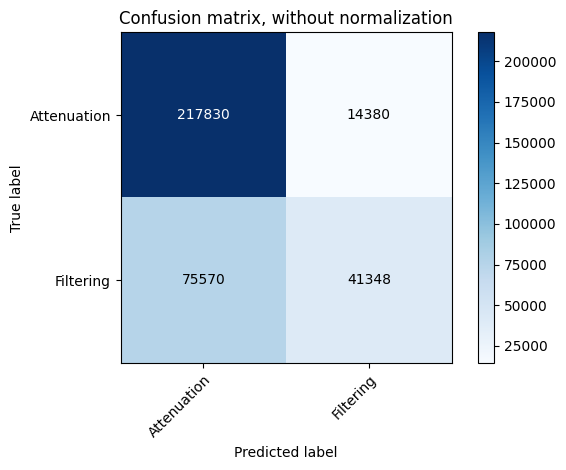

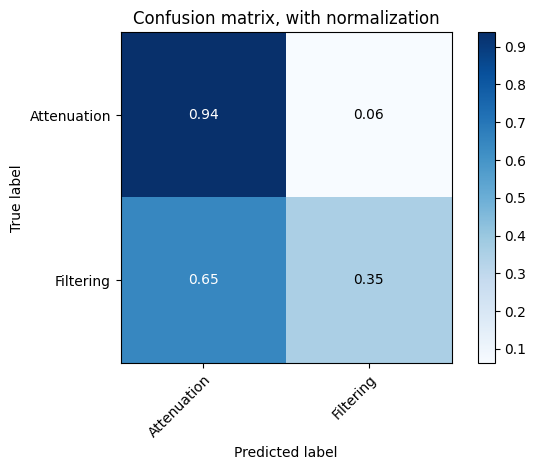

total time=988.194509267807


In [12]:
##############################################################################################################
###### Task 6a) For window length in range(10,101,30) and window spacing = 1, repeat #########################
######          dataset load (task 3b), training and hyperparameter optimization (task 4c), ##################
######          and test and performance evaluation (task 5b), storing global results ########################
######          (accuracy, precision, recall and F1-score) in proper lists for each ML algorithm #############
######          USE ONLY THE ptp FEATURE TO DO THE ENTIRE PROCESS ############################################
######          USE 10%/90% TRAIN/TEST SPLIT TO SPEEDUP THE PROCESS ##########################################
######          Hints: for each metric and each ML algorithm, pre-instantiate np.arrays with dimensions ######
######          of the space (window spacing, window length) #################################################
##############################################################################################################
start=time.time()


#F: these params will be used to iterate over different values of window length...
windowrange=list(range(10,101,30))
#F: ...and window spacing (if needed)
spacingrange=[1]


lbl = [0, 1]
label_names=['Attenuation', 'Filtering']

#F: folder where to put result files
res_folder = 'RESLOOP_Window'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

A_XGB = np.zeros([len(spacingrange),len(windowrange)])
GP_XGB = np.zeros([len(spacingrange),len(windowrange)])
GR_XGB = np.zeros([len(spacingrange),len(windowrange)])
GF1_XGB = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])

A_KNN = np.zeros([len(spacingrange),len(windowrange)])
GP_KNN = np.zeros([len(spacingrange),len(windowrange)])
GR_KNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_KNN = np.zeros([len(spacingrange),len(windowrange)])
############# ADD YOUR CODE BELOW #############


for i, spacing in enumerate(spacingrange): #enumerate(range(minsp,maxsp+1,stepsp)):
    for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
        print('********************************')
        print('Iteration for spacing={} and window length={}'.format(spacing,length))
        
        ####### 1) Load dataset (task 3b) #######
        print('1) Loading dataset into (XX,yy)...')
        
        XX = None
        yy = None
        folderpath='Features'
        
        for filename in os.listdir(folderpath):
            if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                label = 0
                if int(filename[9]) > 5:
                    label = 1
                fullname = folderpath + '/' + filename

                XX, yy = load_window_dataset(XX, yy, fullname, label)

        print(XX)
        XX=XX[:,3:4] #F: use the 3rd feature only (ptp)
        print(XX)
        scaler = StandardScaler()
        XX = scaler.fit_transform(XX)

        ####### 2) Hyperparameters optimization and training (task 4c) #######
        print('2) Hyperparameters optimization and training...')
        resfile_XGB=res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'
        resfile_DNN=res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'
        resfile_KNN=res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + '_results.txt'

        X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.9, random_state=42)
        print('Training XGB...')
        xgb = train_classifier_XGB(X_train, y_train, resfile_XGB)

        print('Training DNN...')
        dnn = train_classifier_DNN(X_train, y_train, resfile_DNN)
        
        print('Training KNN...')
        knn = train_classifier_KNN(X_train, y_train, resfile_KNN)
        
        ####### 3) Predict and performance evaluation (task 5b) #######
        print('3) Predict and performance evaluation...')
        restestfileXGB = res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
        restestfileDNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
        restestfileKNN = res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'


        y_pred_XGB = xgb.predict(X_test)
        y_pred_DNN = dnn.predict(X_test)
        y_pred_KNN = knn.predict(X_test)

        A_XGB[i,j], GP_XGB[i,j], GR_XGB[i,j], GF1_XGB[i,j] = performance_eval(y_test, y_pred_XGB, lbl, label_names, restestfileXGB)
        A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(y_test, y_pred_DNN, lbl, label_names, restestfileDNN)
        A_KNN[i,j], GP_KNN[i,j], GR_KNN[i,j], GF1_KNN[i,j] = performance_eval(y_test, y_pred_KNN, lbl, label_names, restestfileKNN)


end=time.time()


print('total time=' + str(end-start))


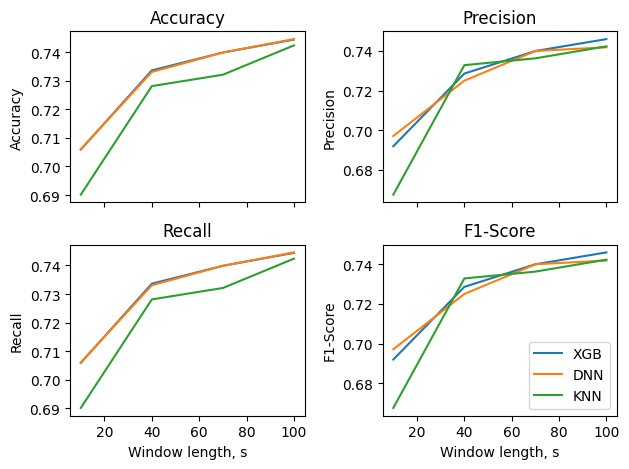

In [13]:
###############################################################################
###### Task 6b) Plot the 4 metrics vs window length in 4 separate graphs ######
######          each graph should include one curve for each ML algorithm #####
###############################################################################

xvalues=np.array(windowrange)

A_XGB = A_XGB.reshape(-1, 1)
GP_XGB = GP_XGB.reshape(-1, 1)
GR_XGB = GR_XGB.reshape(-1, 1)
GF1_XGB = GF1_XGB.reshape(-1, 1)

A_DNN = A_DNN.reshape(-1, 1)
GP_DNN = GP_DNN.reshape(-1, 1)
GR_DNN = GR_DNN.reshape(-1, 1)
GF1_DNN = GF1_DNN.reshape(-1, 1)

A_KNN = A_KNN.reshape(-1, 1)
GP_KNN = GP_KNN.reshape(-1, 1)
GR_KNN = GR_KNN.reshape(-1, 1)
GF1_KNN = GF1_KNN.reshape(-1, 1)

fig, axs = plt.subplots(2, 2, sharex='all')

axs[0,0].plot(xvalues, A_XGB, label = 'XGB')
axs[0,0].plot(xvalues, A_DNN, label = 'DNN')
axs[0,0].plot(xvalues, A_KNN, label = 'KNN')
axs[0,0].set_title('Accuracy')
axs[0,0].set_ylabel('Accuracy')

axs[0,1].plot(xvalues, GP_XGB, label = 'XGB')
axs[0,1].plot(xvalues, GP_DNN, label = 'DNN')
axs[0,1].plot(xvalues, GP_KNN, label = 'KNN')
axs[0,1].set_title('Precision')
axs[0,1].set_ylabel('Precision')

axs[1,0].plot(xvalues, GR_XGB, label = 'XGB')
axs[1,0].plot(xvalues, GR_DNN, label = 'DNN')
axs[1,0].plot(xvalues, GR_KNN, label = 'KNN')
axs[1,0].set_title('Recall')
axs[1,0].set_ylabel('Recall')

axs[1,1].plot(xvalues, GP_XGB, label = 'XGB')
axs[1,1].plot(xvalues, GP_DNN, label = 'DNN')
axs[1,1].plot(xvalues, GP_KNN, label = 'KNN')
axs[1,1].set_title('F1-Score')
axs[1,1].set_ylabel('F1-Score')

axs[1,0].set_xlabel('Window length, s')
axs[1,1].set_xlabel('Window length, s')


axs[1,1].legend(loc='best')

fig.tight_layout()
fig.savefig(res_folder+'/metrics.png')